# AER850 PROJECT 2: Deep Convolutional Neural Networks

# **STEP 1**
Data processing is the first step to perform any type of image classification task. There are a few steps involved with this step.

• The first is to define the input image shape which is required to be (500,500, 3) which is the desired width, height and channel of the image for model training.

• Establish the train and validation data directory (use relative paths). The data is
split into 3 folders - Train, Validation and Test which contain 1942, 431 and 539 images respectively.

• Perform data augmentation such as re-scaling, shear range and zoom range by using
packages such as Keras’ image preprocessing pipeline, or torchvision transforms for the train data and validation data (only apply re-scaling for validation).

• Create the train and validation generator using Keras’s built-in imagedatasetfromdirectory function which takes in the data directory, image target size, batch size (32), and class mode (categorical) or by using PyTorch’s Dataloader .

In [44]:
# Import Libraries for Step 1 (Image Classification)

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [45]:
# Define parameters for image processing

# Resizing all images to 128 x 128 because of computational loss from 500 x 500
img_height = 128
img_width = 128
channels = 3

# Set base directory for train, test and validation data
base_dir = r'C:\Users\shiva\OneDrive\Desktop\AER850\AER850_Project2_ShivamPathak/data'

# Paths to train, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [46]:
# Defining training data transformations (include augmentation)
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(), # left-right flip
    transforms.RandomRotation(10), # randomly rotate +/- 10 deg
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2),shear=10), # shear and zoom
    transforms.ToTensor(),
])

# Defining validation data transformations (only resize)
val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])
# NOTE: This same resize step will be used for test data

# Creating train, test, and validation datasets after transformations from directories
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

In [47]:
# Create DataLoader to load images and labels for training (shuffled)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoaders to load images and labels for test and validation (not shuffled)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check to see if model loads data correctly
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Labels batch shape:", labels.shape)
# Count the number of images in the training dataset
num_train_images = len(train_dataset)
print("Number of training images:", num_train_images)
print("Yes, the model loads the data correctly.")

Image batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])
Number of training images: 1942
Yes, the model loads the data correctly.


# **STEP 2**

For this stage you are required to build your own custom neural network. You are allowed to use any machine learning platform. If you are using Tensorflow or PyTorch, you can start with the following tutorials: Tensorflow CNN Tutorial or Pytorch CNN Tutorial. The neural network will have multiple layers. The layers to extract the features from the given images are outlined below.

• Convolutional layers which are accessed through the Conv2D package which filters the images and extract key features. The three main components to explore within this layer are: number of filters, kernel size, and stride. (The main focus can be on filters and kernel size).

• The next layer is the MaxPooling2D layer which follows the convolutional layers and
pools the extracted features and takes the highest value.

• The Flatten layer is then utilized after all the convolutions and max pooling layers,
which is applied before the dense layers.

• Lastly, the fully connected Dense and Dropout layers are utilized perform the final
predictions. (The final dense should only have 3 neurons, correlating to the label
classes).

• Note: You can adjust the convolutional and fully connected layers to improve the
performance of the network.

In [48]:
# Import libraries for Step 2 (Neural Network Architecture Design)
import torch
import torch.nn as nn

In [49]:
# Establish CNN from PyTorch Library
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeeperCNN, self).__init__()

# 1st Convolutional Layer using Conv2D
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # max pooling layer to downsample

# 2nd Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.5) # dropout for regularization/reduce overfit

# 3rd Convolutional Layer Third block: complex feature detection
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.2) # set 20% of features to zero during training; further reduce overfit
        
 # Fully Connected (Dense) layers
        self.fc1 = nn.Linear(128 * 16 * 16, 144)  # flatten input for dense layer
        self.dropout4 = nn.Dropout(0.5) # prevent co-adaptation of neurons before output
        self.fc2 = nn.Linear(144, num_classes)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x))) # 1st Conv, ReLU, 1st Pool
        x = self.pool2(torch.relu(self.conv2(x))) # 2nd Conv, ReLU, 2nd Pool
        x = self.dropout2(x) # Block 2 Dropout
        x = self.pool3(torch.relu(self.conv3(x))) # 3rd Conv, ReLU, 3rd Pool
        x = self.dropout3(x) # Block 3 Dropout
        x = x.view(x.size(0),-1) # Flatten for dense input
        x = torch.relu(self.fc1(x)) # Dense layer ReLU
        x = self.dropout4(x) # Final Dropout
        x = self.fc2(x) # Output layer, no activation, for CrossEntropyLoss
        return x

model = DeeperCNN(num_classes=3) # Instantiate model
print(model)

DeeperCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32768, out_features=144, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=144, out_features=3, bias=True)
)


# **STEP 3**

Hyperparameters within the neural network architecture are primarily the activation functions within the convolutional and dense layers.

• Common activation functions within the convolutional layers are either ReLU or LeakyReLU. These activation functions provide non-linearity to the layers which lead to better generalizations.

• Common activation functions for the fully connected dense layers are usually ReLU or ELU which are utilized for the same purposes of non-linearity and generalization. Lastly, the activation function of the final layer for a multi-class classification is primarily softmax.

• The number of neurons or filters for the dense and convolutional layers respectively, are other parameters that can be tuned. The filters are usually powers with base of 2 (32, 64, 128, etc), neurons for dense layers can be varied based on the performance of the model.

• The last set of hyperparameters to tune are the loss function and optimizers which are usually variables within keras’s compile function. The loss function and optimizer to start with would be categorical crossentropy and adam, respectively.

In [50]:
import torch.optim as optim # Import optimizer

device = torch.device("cpu")
model = model.to(device) # moving model to cpu

criterion = nn.CrossEntropyLoss() # crossentropy loss function; internal softmax
# Compile model with standard learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

# Print hyperparameter summary for report/verification
print("Model uses ReLU activations in all convolution and dense layers.")
print("Loss function: CrossEntropyLoss (multi-class, applies softmax internally).")
print("Optimizer: Adam with learning rate 0.001.")
print("Number of epochs for training:", num_epochs)

Model uses ReLU activations in all convolution and dense layers.
Loss function: CrossEntropyLoss (multi-class, applies softmax internally).
Optimizer: Adam with learning rate 0.001.
Number of epochs for training: 20


# **STEP 4**

Model evaluation requires the assessment of the loss and accuracy performance of the model. These two components behave inverse to each other where the accuracy is expected to increase and the model loss to decrease. These variables will define the direction in which the model should be tuned to improve the performance of the model. The loss and accuracy for both training and validation should be assessed to check for possibilities of overfitting.

In [51]:
import matplotlib.pyplot as plt

# Create lists to record accuracy and loss for each epoch
train_acc_list, val_acc_list = [],[]
train_loss_list, val_loss_list = [],[]

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Looping over each batch of training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # data to cpu
        optimizer.zero_grad() # zero gradients from previous batch
        outputs = model(images) # forward pass: compute model outputs
        loss = criterion(outputs, labels) # calculate batch loss
        loss.backward() # backward pass: compute gradients
        optimizer.step() # update model weights

        running_loss += loss.item() # accumulate batch loss for average
        _, predicted = torch.max(outputs, 1) # predicting class with highest score
        correct += (predicted == labels).sum().item() # count correct predictions
        total += labels.size(0) # count total predictions

    # Calculate average loss for each epoch
    avg_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_loss)
    # Compute training accuracy for epoch
    train_acc = correct / total
    train_acc_list.append(train_acc)

    # Validation phase (no gradient calculation)
    model.eval() # set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        # Loop over batches in validation data
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
        # Average validation loss and accuracy for epoch
        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        val_acc = val_correct / val_total
        val_acc_list.append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} ")

KeyboardInterrupt: 

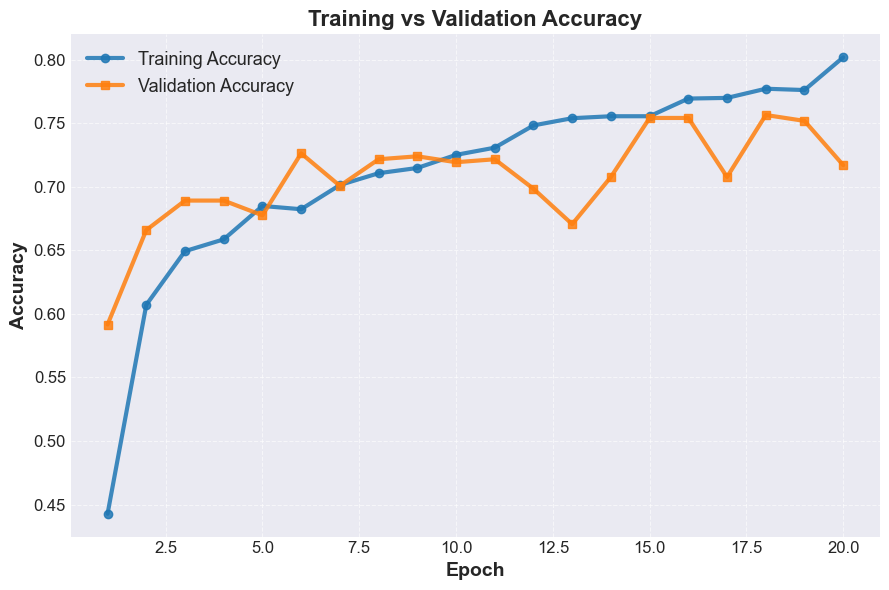

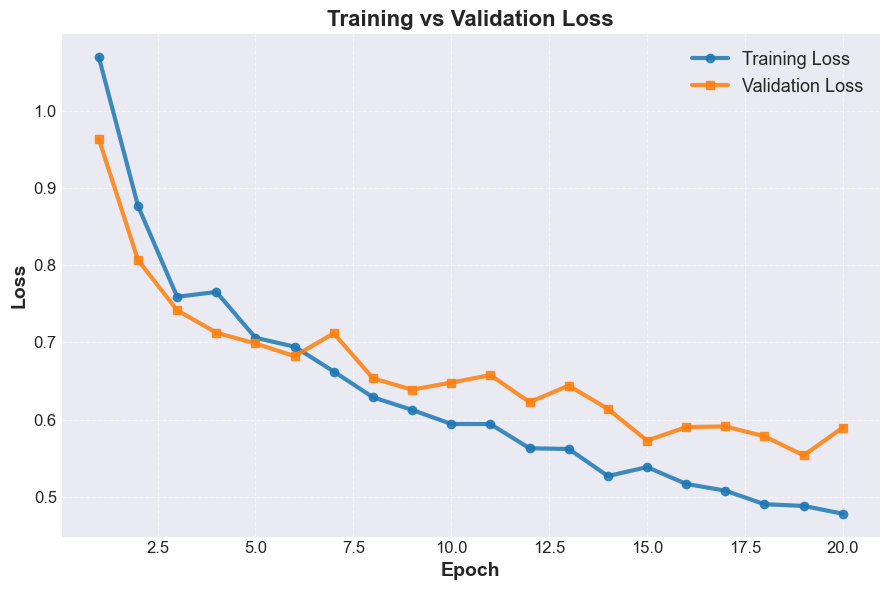

In [40]:
# Plot 1: Training and Validation Accuracy
plt.style.use('seaborn-v0_8-darkgrid')
epochs = range(1, num_epochs+1)
plt.figure(figsize=(9,6))
plt.plot(epochs, train_acc_list, label='Training Accuracy',
         color='#1f77b4', linewidth=3, marker='o', alpha=0.85)
plt.plot(epochs, val_acc_list, label='Validation Accuracy',
         color='#ff7f0e', linewidth=3, marker='s', alpha=0.85)
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Training vs Validation Accuracy', fontsize=16, fontweight='bold')
plt.legend(fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: Training and Validation Loss
plt.figure(figsize=(9,6))
plt.plot(epochs, train_loss_list, label='Training Loss',
         color='#1f77b4', linewidth=3, marker='o', alpha=0.85)
plt.plot(epochs, val_loss_list, label='Validation Loss',
         color='#ff7f0e', linewidth=3, marker='s', alpha=0.85)
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training vs Validation Loss', fontsize=16, fontweight='bold')
plt.legend(fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The training and validation loss curves decrease together and remain closely aligned throughout training, indicating the model is not simply memorizing the training data. Additionally, the training and validation accuracy curves both increase and plateau with only a small gap, confirming strong generalization and minimal overfitting.

In [41]:
# Save the model for use in Step 5
torch.save(model.state_dict(), 'p2_DCNN_Model.pt')